In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn
seaborn.set()





In [2]:
beers = pd.read_csv("./data/beerinfo.csv")


/Users/jameshopkins/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
canadian_breweries = pd.read_csv('./data/breweryinfo.csv')
canadian_breweries = canadian_breweries[canadian_breweries['country'] == 'Canada']

In [4]:
beer_df = beers.merge(canadian_breweries, on = 'brewery_number', how = "inner")

In [5]:
beer_df.columns

Index(['abv', 'availability', 'ba_score', 'beer_name', 'beer_number',
       'brewery_name_x', 'brewery_number', 'notes', 'pdev', 'ranking',
       'ratings', 'reviews', 'style', 'beer_ratings', 'beer_reviews',
       'beer_score', 'beers', 'brewery_name_y', 'brewery_pdev',
       'brewery_ratings', 'brewery_review', 'brewery_score', 'city', 'country',
       'province'],
      dtype='object')

In [6]:
print(beer_df.groupby('province').mean())
print(beer_df['province'].value_counts())

                                abv  ba_score  beer_score      beers  \
province                                                               
Alberta                    5.772754  3.610820    3.668540  41.172000   
British Columbia           5.942206  3.301632    3.743950  37.942827   
Manitoba                   5.622059  2.802222    2.900000   9.833333   
New Brunswick              5.943396  2.456592    3.511883  33.887892   
Newfoundland and Labrador  5.386364  3.521778    3.599333   9.755556   
Northwest Territories      5.550000  0.930000    3.720000   4.000000   
Nova Scotia                6.058186  3.355618    3.741673  18.071713   
Nunavut                    5.000000  3.830000    3.830000   1.000000   
Ontario                    5.857686  3.253552    3.640536  42.023429   
Prince Edward Island       5.423077  3.351220    3.640976  14.853659   
Quebec                     6.408386  2.894937    3.629596  66.667298   
Saskatchewan               6.113855  3.326196    3.729348  17.34

In [7]:
beer_df['ratings'] = beer_df['ratings'].str.replace(',', '').astype(float)

In [8]:
#drop beers that don't get rated much and drop 
min_ratings = beer_df[beer_df['ratings'] >= 10]
min_ratings = min_ratings.dropna(0)


In [9]:
#pull out categorical variables we can look at
min_ratings_X = min_ratings[['availability', 'style', 'abv', 'ratings']]
ratings_y = min_ratings['ba_score']
#OK so there is an average of 15.5833 beers per style, but with a giant standard deviation


In [10]:
#source https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512
#This labels styles with fewer than ten examples in the data as "Rare"


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(min_ratings_X)
X_train_one_hot = enc.transform(min_ratings_X)


In [12]:
#TODO: fix onehotencoding so that it only does it for the categorical variables

reg = stats.linregress(np.log10(min_ratings_X['abv']), ratings_y)
min_ratings_X['prediction'] = np.log10(min_ratings_X['abv'])*reg.slope + reg.intercept

/Users/jameshopkins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
print('p-value:')
print(reg.pvalue)
print('r^2 value:')
print(reg.rvalue**2)


p-value:
2.516697400210055e-54
r^2 value:
0.19328933153222386


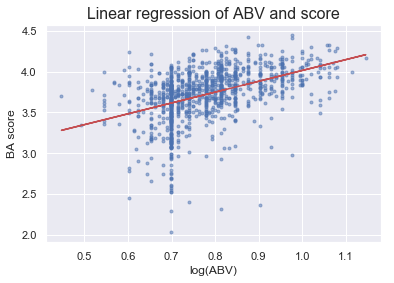

In [14]:
plt.plot(np.log10(min_ratings_X['abv']), ratings_y, 'b.', alpha=0.5)
plt.plot(np.log10(min_ratings_X['abv']), min_ratings_X['prediction'], 'r-')

plt.xlabel('log(ABV)')
plt.ylabel('BA score')
plt.title('Linear regression of ABV and score', fontsize = 16)
plt.savefig('linear_regression.png')
plt.show()

In [15]:
set(min_ratings['availability'])

{'Fall',
 'Limited (brewed once)',
 'Rotating',
 'Spring',
 'Summer',
 'Winter',
 'Year-round'}

In [16]:
from scipy import stats
fall = min_ratings[min_ratings['availability'] == 'Fall']['ba_score']
limited = min_ratings[min_ratings['availability'] == 'Limited (brewed once)']['ba_score']
rotating = min_ratings[min_ratings['availability'] == 'Rotating']['ba_score']
spring = min_ratings[min_ratings['availability'] == 'Spring']['ba_score']
summer = min_ratings[min_ratings['availability'] == 'Summer']['ba_score']
winter = min_ratings[min_ratings['availability'] == 'Winter']['ba_score']
year = min_ratings[min_ratings['availability'] == 'Year-round']['ba_score']


In [17]:
#non parametric test to replace anova because of heterogeniety of variances


KruskalResult(statistic=193.40665360830042, pvalue=4.798582743403417e-39)


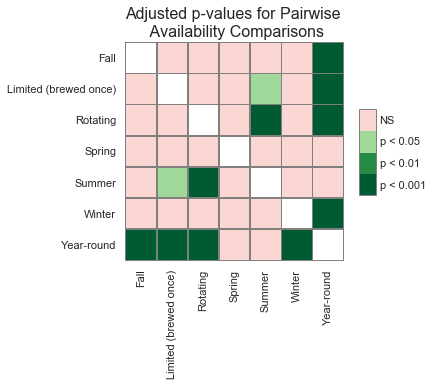

In [18]:
print(stats.kruskal(fall, limited, rotating, spring, summer, winter, year))
pc = sp.posthoc_conover(min_ratings, val_col='ba_score', group_col='availability', p_adjust = 'holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
plt.title("Adjusted p-values for Pairwise \n Availability Comparisons", fontsize=16)
heatmap_1 = sp.sign_plot(pc, **heatmap_args)


In [19]:
min_ratings.loc[min_ratings['style'].value_counts()[min_ratings['style']].values < 16, 'style'] = "Rare"
#min_ratings = min_ratings[min_ratings['style'].value_counts()[min_ratings['style']].values > 10]

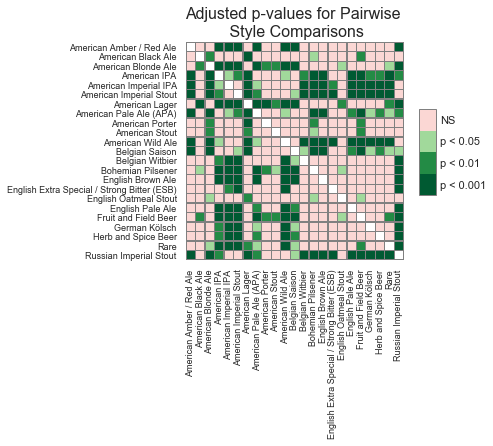

In [20]:

pc = sp.posthoc_conover(min_ratings, val_col='ba_score', group_col='style', p_adjust = 'holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
plt.title("Adjusted p-values for Pairwise \n Style Comparisons", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=9)
heatmap_2 = sp.sign_plot(pc, **heatmap_args)

In [21]:
#for analysis of variance with provinces remove provinces that have less than 10 observations 

reg_data = min_ratings[min_ratings['province'] != 'Prince Edward Island']
reg_data = reg_data[reg_data['province'] != 'Newfoundland and Labrador']

Alberta = reg_data[reg_data['province'] == 'Alberta']['ba_score']
BC = reg_data[reg_data['province'] == 'British Columbia']['ba_score']
NB = reg_data[reg_data['province'] == 'New Brunswick']['ba_score']
NS = reg_data[reg_data['province'] == 'Nova Scotia']['ba_score']
Ontario = reg_data[reg_data['province'] == 'Ontario']['ba_score']
Quebec = reg_data[reg_data['province'] == 'Quebec']['ba_score']
Sask = reg_data[reg_data['province'] == 'Saskatchewan']['ba_score']



KruskalResult(statistic=32.462314571743796, pvalue=1.3303229899993065e-05)


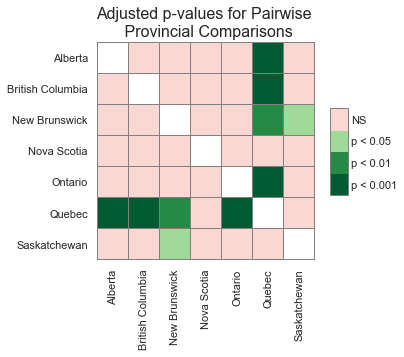

In [22]:
print(stats.kruskal(Alberta, BC, NB, NS, Ontario, Quebec, Sask))

pc = sp.posthoc_conover(reg_data, val_col='abv', group_col='province', p_adjust = 'holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
plt.title("Adjusted p-values for Pairwise \n Provincial Comparisons", fontsize=16)
heatmap_3 = sp.sign_plot(pc, **heatmap_args)


In [23]:


heatmap_1[0].figure.savefig("heatmap1.png", bbox_inches = "tight")
heatmap_2[0].figure.savefig("heatmap2.png", bbox_inches = "tight")
heatmap_3[0].figure.savefig("heatmap3.png", bbox_inches = "tight")


In [29]:



style_dummies = pd.get_dummies(min_ratings['style'])
availability_dummies = pd.get_dummies(min_ratings['availability'])
province_dummies = pd.get_dummies(min_ratings['province'])
dummies = style_dummies.join(availability_dummies).join(province_dummies)

dummies = dummies.join(min_ratings)
dummies['BC'] = dummies['British Columbia']
dummies['NS'] = dummies['Nova Scotia']
dummies['NB'] = dummies['New Brunswick']
dummies['logabv'] = np.log(dummies['abv'])
dummies['year'] = dummies['Year-round']
dummies['maritimes'] = np.where(dummies['NB'] | dummies['NS'] == 1, 1, 0 )
dummies['west'] = np.where(dummies['BC'] | dummies['Alberta'] | dummies['Saskatchewan'] == 1, 1, 0 )

dummies.loc[dummies.west == 1, 'region'] = 'West'
dummies.loc[dummies.Quebec == 1, 'region'] = 'Quebec'
dummies.loc[dummies.maritimes == 1, 'region'] = 'Maritimes'
dummies.loc[dummies.Ontario == 1, 'region'] = 'Ontario'


In [30]:
print(dummies[['west','abv']].groupby('west').mean())
print(dummies[['west','year']].groupby('west').mean())

           abv
west          
0     6.269109
1     6.076986
          year
west          
0     0.403736
1     0.422897


In [31]:
dummies['maritimes'].value_counts()
dummies['NB'].value_counts()

0    1107
1      17
Name: NB, dtype: int64

In [32]:
#https://etav.github.io/python/vif_factor_python.html
#calculating variance inflation factors to determine if the independent variables are truly independent 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('ba_score ~ logabv + year + west', dummies, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

   VIF Factor   features
0   64.932498  Intercept
1    1.094419     logabv
2    1.092254       year
3    1.002366       west


In [33]:

mod = smf.ols(formula='ba_score ~ logabv + year + west', data= dummies)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ba_score   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     136.9
Date:                Fri, 02 Aug 2019   Prob (F-statistic):           1.54e-75
Time:                        20:54:18   Log-Likelihood:                -145.61
No. Observations:                1124   AIC:                             299.2
Df Residuals:                    1120   BIC:                             319.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9145      0.066     43.945      0.0